In [55]:
# Basic packages
import matplotlib.pyplot as plt
import numpy as np

# Scipy packages
from ISLP import confusion_table
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as skm
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RC
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, 
                                           QuadraticDiscriminantAnalysis as QDA)


# Dataset packages
import torchvision
import torchvision.transforms as transforms

# Torch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset # To extract a subset of thr training data
from torchinfo import summary

In [56]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]) # The first one corresponds to the mean per channel,
                                           # The second is the std per sample
                                           # (Input - Mean)/Std   [0,1] --> [-1,1]

full_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True,transform=transform)
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

# There will be 10 classes in total
classes = full_trainset.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [57]:
subset_indices = np.arange(1000)
trainset       = Subset(full_trainset, subset_indices)

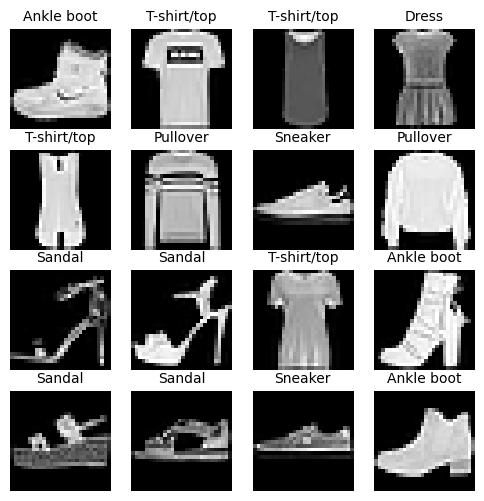

In [58]:
# Plot a few samples to visualize the data

fig,axs = plt.subplots(4,4,figsize=(6,6))
axs = axs.flatten()
for i in range(16):
    img = trainset[i][0].numpy().squeeze()
    axs[i].imshow(img,cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"{classes[trainset[i][1]]}",fontsize=10)

In [59]:
X_train_flat = np.array([trainset[i][0].flatten() for i in range(1000)])
Y_train      = np.array([trainset[i][1] for i in range(1000)])
X_test_flat  = np.array([testset[i][0].flatten() for i in range(testset.data.shape[0])])
Y_test       = np.array([testset[i][1] for i in range(testset.data.shape[0])])

In [60]:
print(X_train_flat.shape)
print(Y_train.shape)
print(X_test_flat.shape)
print(Y_test.shape)

(1000, 784)
(1000,)
(10000, 784)
(10000,)


In [61]:
# Apply PCA to training data 
pca = PCA(svd_solver='full') 
pca.fit(X_train_flat)

# Explained variance ratio
var_explained = np.cumsum(pca.explained_variance_ratio_)

# Find number of components to explain > 90% variance
pca_dim = np.argmax(var_explained > 0.90) + 1
print(f"Number of dimensions to explain 90% variance: {pca_dim}")

# Transform data into lower-dimensional space
X_pca_train = pca.transform(X_train_flat)[:, :pca_dim]
print(X_pca_train.shape)  # should be [n_samples, pca_dim]

# Apply the trained PCA to test data
X_pca_test_full = pca.transform(X_test_flat)  # Full PCA transform
X_pca_test = X_pca_test_full[:, :pca_dim]     # Slice to retained dimensions

Number of dimensions to explain 90% variance: 69
(1000, 69)


In [62]:
def acc_table(pred_labels,true_labels,print_class_accuracy = True):
    tab = np.array(confusion_table(true_labels,pred_labels))
    n_samples = true_labels.size

    total_acc = 0.0;
    class_acc = np.zeros(len(classes))
    for i,cn in enumerate(classes):
        class_acc[i] = float(tab[i,i])/float(sum(tab[i]))*100.0
        total_acc += float(tab[i,i])
        if print_class_accuracy:
            print(f'Accuracy for class: {cn:5s} is {class_acc[i]:.2f} %')
    total_acc *=100.0/n_samples
    print(f'Total accuracy is {total_acc:.2f} %')
    return class_acc, total_acc
        

In [63]:
# PART 1: KNN Classification

In [64]:
k_vals = [1,3,5,7,9,11]
kfold = skm.KFold(5, random_state=0, shuffle = True)
grid_model = skm.GridSearchCV(KNeighborsClassifier(), {'n_neighbors':k_vals}, refit=True,cv=kfold, scoring = 'accuracy')
grid_model.fit(X_train_flat, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11]},
             scoring='accuracy')

In [65]:
grid_model.fit(X_pca_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11]},
             scoring='accuracy')

In [66]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_flat, Y_train)         # Train the model
knn_label = knn.predict(X_test_flat)   # Predict on test data
    
# Calculate accuracy
knn_acc = acc_table(knn_label, Y_test, print_class_accuracy = True)

Accuracy for class: T-shirt/top is 77.50 %
Accuracy for class: Trouser is 93.20 %
Accuracy for class: Pullover is 60.40 %
Accuracy for class: Dress is 69.90 %
Accuracy for class: Coat  is 61.00 %
Accuracy for class: Sandal is 62.40 %
Accuracy for class: Shirt is 49.50 %
Accuracy for class: Sneaker is 92.00 %
Accuracy for class: Bag   is 90.60 %
Accuracy for class: Ankle boot is 94.10 %
Total accuracy is 75.06 %


In [67]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_pca_train, Y_train)
knn_label = knn.predict(X_pca_test)

knn_pca_acc = acc_table(knn_label, Y_test, print_class_accuracy = True)

Accuracy for class: T-shirt/top is 74.50 %
Accuracy for class: Trouser is 93.30 %
Accuracy for class: Pullover is 56.80 %
Accuracy for class: Dress is 73.10 %
Accuracy for class: Coat  is 64.00 %
Accuracy for class: Sandal is 69.20 %
Accuracy for class: Shirt is 47.70 %
Accuracy for class: Sneaker is 90.40 %
Accuracy for class: Bag   is 92.70 %
Accuracy for class: Ankle boot is 94.20 %
Total accuracy is 75.59 %


In [68]:
# PART 2: Linear SVM Classification on PCA data

In [69]:
C_vals = [0.001,0.01,0.1,10.0,100.0]
kfold = skm.KFold(5, random_state=0, shuffle = True)
grid_model = skm.GridSearchCV(SVC(kernel = 'linear'), {'C':C_vals} , refit=True,cv=kfold, scoring = 'accuracy')
grid_model.fit(X_pca_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(kernel='linear'),
             param_grid={'C': [0.001, 0.01, 0.1, 10.0, 100.0]},
             scoring='accuracy')

In [70]:
svm_linear = SVC(C=0.01, kernel = 'linear')
svm_linear.fit(X_pca_train, Y_train)
svm_label = svm_linear.predict(X_pca_test)

In [71]:
svm_acc = acc_table(svm_label, Y_test, print_class_accuracy = True)

Accuracy for class: T-shirt/top is 82.10 %
Accuracy for class: Trouser is 93.00 %
Accuracy for class: Pullover is 62.10 %
Accuracy for class: Dress is 82.90 %
Accuracy for class: Coat  is 70.80 %
Accuracy for class: Sandal is 85.70 %
Accuracy for class: Shirt is 50.20 %
Accuracy for class: Sneaker is 86.00 %
Accuracy for class: Bag   is 91.00 %
Accuracy for class: Ankle boot is 92.10 %
Total accuracy is 79.59 %


In [72]:
# PART 3: Nonlinear SVM classification on PCA data

In [73]:
C_vals = [0.001,0.01,0.1,10.0,100.0]
gamma_vals  = [0.0001,0.001,0.01,0.1,1.0]
grid_model = skm.GridSearchCV(SVC(kernel = 'rbf'), {'C':C_vals, 'gamma':gamma_vals}, refit=True,cv=kfold, scoring = 'accuracy')
grid_model.fit(X_pca_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 10.0, 100.0],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0]},
             scoring='accuracy')

In [74]:
svm_nonlinear = SVC(C=10.0, gamma = 0.001, kernel = 'rbf')
svm_nonlinear.fit(X_pca_train, Y_train)
svmnl_label = svm_nonlinear.predict(X_pca_test)

In [75]:
svmnl_acc = acc_table(svmnl_label, Y_test, print_class_accuracy = True)

Accuracy for class: T-shirt/top is 80.80 %
Accuracy for class: Trouser is 94.20 %
Accuracy for class: Pullover is 66.20 %
Accuracy for class: Dress is 83.80 %
Accuracy for class: Coat  is 71.50 %
Accuracy for class: Sandal is 87.10 %
Accuracy for class: Shirt is 50.50 %
Accuracy for class: Sneaker is 87.90 %
Accuracy for class: Bag   is 92.70 %
Accuracy for class: Ankle boot is 92.70 %
Total accuracy is 80.74 %


In [76]:
# PART 4: Random Forest on PCA data

In [77]:
B = 500
p = X_pca_train.shape[1]
m = int(np.sqrt(p))
bag_tree = RC(max_features = m, 
              n_estimators = B,
              oob_score = True,
              random_state =0)
bag_tree.fit(X_pca_train, Y_train)
bag_tree_label = bag_tree.predict(X_pca_test)
ctable = confusion_table(bag_tree_label, Y_test)
print(ctable)

Truth        0    1    2    3    4    5    6    7    8    9
Predicted                                                  
0          814   22   10   67    4    1  218    0    2    0
1            0  920    0   11    1    0    1    0    2    0
2           20   14  624    5  117    0  142    0    8    0
3           26   31   16  829   61    2   34    0    4    0
4            8    8  209   22  698    0   89    0    5    0
5           12    0    6    4    3  824    9   51   18   23
6          100    2  114   52  102    5  465    0   30    1
7            0    0    0    0    0   89    1  865   11   37
8           20    3   21   10   14   12   41    2  918    2
9            0    0    0    0    0   67    0   82    2  937


In [78]:
print(f"Random forrest OOB test accuracy estimate = {bag_tree.oob_score_}")
tree_acc = acc_table(bag_tree_label, Y_test, print_class_accuracy = True)

Random forrest OOB test accuracy estimate = 0.81
Accuracy for class: T-shirt/top is 81.40 %
Accuracy for class: Trouser is 92.00 %
Accuracy for class: Pullover is 62.40 %
Accuracy for class: Dress is 82.90 %
Accuracy for class: Coat  is 69.80 %
Accuracy for class: Sandal is 82.40 %
Accuracy for class: Shirt is 46.50 %
Accuracy for class: Sneaker is 86.50 %
Accuracy for class: Bag   is 91.80 %
Accuracy for class: Ankle boot is 93.70 %
Total accuracy is 78.94 %


In [79]:
# PART 5 LDA and QDA on PCA data

In [80]:
lda = LDA(store_covariance=True)
lda.fit(X_pca_train,Y_train)
lda_label = lda.predict(X_pca_test)

In [81]:
lda_acc = acc_table(lda_label, Y_test, print_class_accuracy = True)

Accuracy for class: T-shirt/top is 79.00 %
Accuracy for class: Trouser is 91.20 %
Accuracy for class: Pullover is 58.50 %
Accuracy for class: Dress is 76.50 %
Accuracy for class: Coat  is 67.80 %
Accuracy for class: Sandal is 86.60 %
Accuracy for class: Shirt is 51.70 %
Accuracy for class: Sneaker is 81.30 %
Accuracy for class: Bag   is 88.70 %
Accuracy for class: Ankle boot is 93.70 %
Total accuracy is 77.50 %


In [82]:
qda = QDA(store_covariance=True)
qda.fit(X_pca_train,Y_train)
qda_label = qda.predict(X_pca_test)

C:\Users\cheft\anaconda3\envs\islp\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\cheft\anaconda3\envs\islp\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 7 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [83]:
qda_acc = acc_table(qda_label, Y_test, print_class_accuracy = True)

Accuracy for class: T-shirt/top is 62.90 %
Accuracy for class: Trouser is 88.30 %
Accuracy for class: Pullover is 22.20 %
Accuracy for class: Dress is 70.00 %
Accuracy for class: Coat  is 64.10 %
Accuracy for class: Sandal is 85.20 %
Accuracy for class: Shirt is 65.80 %
Accuracy for class: Sneaker is 72.00 %
Accuracy for class: Bag   is 95.80 %
Accuracy for class: Ankle boot is 92.60 %
Total accuracy is 71.89 %


In [84]:
# PART 6:

In [85]:
import pandas as pd
b = {
    "Method" : ["KNN Classification full", "KNN Classification PCA", "Linear SVM PCA", "Nonlinear SVM PCA", "Random Forrest PCA", "LDA PCA", "QDA PCA"],
    "Total Test Accuracy" : [75.06, 75.59, 79.59, 80.74, 78.94, 77.50, 71.89]
}

df = pd.DataFrame(b)
print(df)

                    Method  Total Test Accuracy
0  KNN Classification full                75.06
1   KNN Classification PCA                75.59
2           Linear SVM PCA                79.59
3        Nonlinear SVM PCA                80.74
4       Random Forrest PCA                78.94
5                  LDA PCA                77.50
6                  QDA PCA                71.89


In [86]:
c = {
    "Class" : ["Tshirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"],
    "KNN Full Class Wise Acc" : knn_acc[0], 
    "KNN PCA Class Wise Acc" : knn_pca_acc[0],
    "Linear SVM Class Wise Acc" : svm_acc[0],
    "Nonlinear SVM Class Wise Acc": svmnl_acc[0],
    "Random Forest Class Wise Acc": tree_acc[0],
    "LDA Class Wise Acc": lda_acc[0],
    "QDA Class Wise Acc": qda_acc[0],
}
df2 = pd.DataFrame(c)
print(df2)

        Class  KNN Full Class Wise Acc  KNN PCA Class Wise Acc  \
0  Tshirt/Top                     77.5                    74.5   
1     Trouser                     93.2                    93.3   
2    Pullover                     60.4                    56.8   
3       Dress                     69.9                    73.1   
4        Coat                     61.0                    64.0   
5      Sandal                     62.4                    69.2   
6       Shirt                     49.5                    47.7   
7     Sneaker                     92.0                    90.4   
8         Bag                     90.6                    92.7   
9  Ankle boot                     94.1                    94.2   

   Linear SVM Class Wise Acc  Nonlinear SVM Class Wise Acc  \
0                       82.1                          80.8   
1                       93.0                          94.2   
2                       62.1                          66.2   
3                       8

In [87]:
# PART 7: Training a CNN on the Image Data

In [88]:
batch_size  = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

In [89]:
class Net(nn.Module):
    def __init__(self,dropout_param = 0.5):
        super(Net, self).__init__()

        layer_list = []
        layer_list += [nn.Conv2d(1, 16, 3,padding="same"),nn.ReLU()]
        layer_list += [nn.MaxPool2d(2, 2)]
        layer_list += [nn.Conv2d(16, 32, 3,padding="same"),nn.ReLU()]
        layer_list += [nn.MaxPool2d(2, 2)]
        layer_list += [nn.Flatten(),nn.Dropout(dropout_param)]
        layer_list += [nn.Linear(1568, 128),nn.ReLU(),nn.Dropout(dropout_param)]
        layer_list += [nn.Linear(128, 10)]
        self.model = nn.ModuleList(layer_list)

    def forward(self, x):
        for i, layer in enumerate(self.model):
          x = layer(x) 
        return x




In [90]:
net = Net(dropout_param=0.5)
summary(net,
        input_size=(10,1,28,28),
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Net                                      [10, 1, 28, 28]           [10, 10]                  --
├─ModuleList: 1-1                        --                        --                        --
│    └─Conv2d: 2-1                       [10, 1, 28, 28]           [10, 16, 28, 28]          160
│    └─ReLU: 2-2                         [10, 16, 28, 28]          [10, 16, 28, 28]          --
│    └─MaxPool2d: 2-3                    [10, 16, 28, 28]          [10, 16, 14, 14]          --
│    └─Conv2d: 2-4                       [10, 16, 14, 14]          [10, 32, 14, 14]          4,640
│    └─ReLU: 2-5                         [10, 32, 14, 14]          [10, 32, 14, 14]          --
│    └─MaxPool2d: 2-6                    [10, 32, 14, 14]          [10, 32, 7, 7]            --
│    └─Flatten: 2-7                      [10, 32, 7, 7]            [10, 1568]                --
│    └─Dropout: 2-8            

In [91]:
criterion = nn.CrossEntropyLoss()

In [92]:
optimizer = optim.Adam(net.parameters())
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'Epoch:{epoch + 1}, loss: {running_loss / len(trainloader):.3f}')
print('Finished Training')

Epoch:1, loss: 2.219
Epoch:2, loss: 1.714
Epoch:3, loss: 1.243
Epoch:4, loss: 1.104
Epoch:5, loss: 0.950
Epoch:6, loss: 0.836
Epoch:7, loss: 0.811
Epoch:8, loss: 0.773
Epoch:9, loss: 0.689
Epoch:10, loss: 0.677
Epoch:11, loss: 0.641
Epoch:12, loss: 0.604
Epoch:13, loss: 0.614
Epoch:14, loss: 0.570
Epoch:15, loss: 0.576
Epoch:16, loss: 0.527
Epoch:17, loss: 0.500
Epoch:18, loss: 0.494
Epoch:19, loss: 0.473
Epoch:20, loss: 0.468
Epoch:21, loss: 0.461
Epoch:22, loss: 0.446
Epoch:23, loss: 0.459
Epoch:24, loss: 0.438
Epoch:25, loss: 0.443
Epoch:26, loss: 0.428
Epoch:27, loss: 0.408
Epoch:28, loss: 0.396
Epoch:29, loss: 0.388
Epoch:30, loss: 0.396
Epoch:31, loss: 0.406
Epoch:32, loss: 0.376
Epoch:33, loss: 0.366
Epoch:34, loss: 0.375
Epoch:35, loss: 0.347
Epoch:36, loss: 0.346
Epoch:37, loss: 0.344
Epoch:38, loss: 0.350
Epoch:39, loss: 0.345
Epoch:40, loss: 0.333
Epoch:41, loss: 0.342
Epoch:42, loss: 0.317
Epoch:43, loss: 0.290
Epoch:44, loss: 0.276
Epoch:45, loss: 0.300
Epoch:46, loss: 0.3

In [93]:
net.eval()

N_test = testset.data.shape[0]
pred_labels = np.zeros(N_test)
true_labels = testset.targets.numpy()
i0 = 0
i1 = batch_size
with torch.no_grad():
    for data in testloader:
        images, _ = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted_batch = torch.max(outputs, 1)
        pred_labels[i0:i1] = np.copy(predicted_batch)
        i0 = min(i0 + batch_size,N_test)
        i1 = min(i1 + batch_size,N_test)

acc_table(pred_labels,true_labels);


Accuracy for class: T-shirt/top is 80.30 %
Accuracy for class: Trouser is 97.10 %
Accuracy for class: Pullover is 66.20 %
Accuracy for class: Dress is 81.90 %
Accuracy for class: Coat  is 77.00 %
Accuracy for class: Sandal is 91.60 %
Accuracy for class: Shirt is 51.00 %
Accuracy for class: Sneaker is 93.00 %
Accuracy for class: Bag   is 95.50 %
Accuracy for class: Ankle boot is 93.90 %
Total accuracy is 82.75 %


In [94]:
# PART 8: Training a CNN on the FULL image data

In [95]:
batch_size  = 100
trainloader = torch.utils.data.DataLoader(full_trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

In [96]:
class Net(nn.Module):
    def __init__(self,dropout_param = 0.5):
        super(Net, self).__init__()

        layer_list = []
        layer_list += [nn.Conv2d(1, 16, 3,padding="same"),nn.ReLU()]
        layer_list += [nn.MaxPool2d(2, 2)]
        layer_list += [nn.Conv2d(16, 32, 3,padding="same"),nn.ReLU()]
        layer_list += [nn.MaxPool2d(2, 2)]
        layer_list += [nn.Flatten(),nn.Dropout(dropout_param)]
        layer_list += [nn.Linear(1568, 128),nn.ReLU(),nn.Dropout(dropout_param)]
        layer_list += [nn.Linear(128, 10)]
        self.model = nn.ModuleList(layer_list)

    def forward(self, x):
        for i, layer in enumerate(self.model):
          x = layer(x) 
        return x




In [97]:
net = Net(dropout_param=0.5)
summary(net,
        input_size=(10,1,28,28),
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Net                                      [10, 1, 28, 28]           [10, 10]                  --
├─ModuleList: 1-1                        --                        --                        --
│    └─Conv2d: 2-1                       [10, 1, 28, 28]           [10, 16, 28, 28]          160
│    └─ReLU: 2-2                         [10, 16, 28, 28]          [10, 16, 28, 28]          --
│    └─MaxPool2d: 2-3                    [10, 16, 28, 28]          [10, 16, 14, 14]          --
│    └─Conv2d: 2-4                       [10, 16, 14, 14]          [10, 32, 14, 14]          4,640
│    └─ReLU: 2-5                         [10, 32, 14, 14]          [10, 32, 14, 14]          --
│    └─MaxPool2d: 2-6                    [10, 32, 14, 14]          [10, 32, 7, 7]            --
│    └─Flatten: 2-7                      [10, 32, 7, 7]            [10, 1568]                --
│    └─Dropout: 2-8            

In [98]:
criterion = nn.CrossEntropyLoss()

In [99]:
optimizer = optim.Adam(net.parameters())
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'Epoch:{epoch + 1}, loss: {running_loss / len(trainloader):.3f}')
print('Finished Training')

Epoch:1, loss: 0.628
Epoch:2, loss: 0.421
Epoch:3, loss: 0.376
Epoch:4, loss: 0.347
Epoch:5, loss: 0.330
Epoch:6, loss: 0.314
Epoch:7, loss: 0.303
Epoch:8, loss: 0.293
Epoch:9, loss: 0.287
Epoch:10, loss: 0.279
Finished Training


In [100]:
net.eval()

N_test = testset.data.shape[0]
pred_labels = np.zeros(N_test)
true_labels = testset.targets.numpy()
i0 = 0
i1 = batch_size
with torch.no_grad():
    for data in testloader:
        images, _ = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted_batch = torch.max(outputs, 1)
        pred_labels[i0:i1] = np.copy(predicted_batch)
        i0 = min(i0 + batch_size,N_test)
        i1 = min(i1 + batch_size,N_test)

acc_table(pred_labels,true_labels);


Accuracy for class: T-shirt/top is 87.50 %
Accuracy for class: Trouser is 97.70 %
Accuracy for class: Pullover is 83.90 %
Accuracy for class: Dress is 91.10 %
Accuracy for class: Coat  is 89.30 %
Accuracy for class: Sandal is 98.50 %
Accuracy for class: Shirt is 71.40 %
Accuracy for class: Sneaker is 97.30 %
Accuracy for class: Bag   is 98.20 %
Accuracy for class: Ankle boot is 96.10 %
Total accuracy is 91.10 %
